In [1]:

import os

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, LearningRateScheduler
from tensorflow.keras.metrics import top_k_categorical_accuracy
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.applications import InceptionV3

In [2]:
experiments_path = '/data/alberto/iWildCam2020/experiments'
experiment = 'inceptionv3_train_balanced'

### Configurações de treino

In [3]:
def tl_scheduler(epoch):
    if epoch < 6:
        return 0.005
    elif epoch < 11:
        return 0.001
    elif epoch < 21:
        return 0.005
    elif epoch < 28:
        return 0.001
    elif epoch < 36:
        return 0.0005
    else:
        return 0.0001

In [4]:
training_config = {
    'batch_size': 32,
    'target_size': (299,299),
    'epochs': 30,
    'lr': 0.005,
    'decay': 0,
    'seed': 42
}

### Carregando dataset iwildcam

In [5]:
train_dir = '/data/alberto/iWildCam2020/balanced_resized/balanced_train_resized'
validation_dir = '/data/alberto/iWildCam2020/balanced_resized/balanced_validation_resized'

In [6]:

train_datagen = ImageDataGenerator(rotation_range=20,
                                   zoom_range=0.15,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.15,
                                   horizontal_flip=True,
                                   fill_mode="nearest")

validation_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=training_config['target_size'],
        batch_size=training_config['batch_size'],
        class_mode='categorical',
        shuffle=True,
        seed=training_config['seed'])

validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=training_config['target_size'],
        batch_size=training_config['batch_size'],
        class_mode='categorical',
        classes=sorted(list(train_generator.class_indices.keys())))

Found 148355 images belonging to 3 classes.
Found 22571 images belonging to 3 classes.


### Callbacks

In [7]:
model_path = os.path.join(experiments_path, experiment, 'models', 'weights.{epoch:02d}-{val_accuracy:.2f}.hdf5')
if not os.path.exists(os.path.dirname(model_path)):
    os.makedirs(os.path.dirname(model_path))

checkpoint = ModelCheckpoint(
    filepath=model_path,
    monitor='val_accuracy'
)

checkpoint_best = ModelCheckpoint(
    filepath=os.path.join(experiments_path, experiment, 'models', 'best.hdf5'),
    save_best_only=True,
    monitor='val_accuracy'
)

csv_path = os.path.join(experiments_path, experiment, 'history', 'training.log')
if not os.path.exists(os.path.dirname(csv_path)):
    os.makedirs(os.path.dirname(csv_path))

csv_logger = CSVLogger(csv_path, append=True)

lr_scheduler = LearningRateScheduler(tl_scheduler)

In [8]:
callbacks = [checkpoint, checkpoint_best, csv_logger, lr_scheduler]

### Métricas

In [9]:
def top_5_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=5)


### Construindo modelo

In [10]:
base_model = InceptionV3(input_shape=(299,299,3), weights='imagenet', include_top=False)
x = GlobalAveragePooling2D()(base_model.output)
output = Dense(len(validation_generator.class_indices), activation='softmax')(x)
model = Model(inputs=[base_model.input], outputs=[output])

In [11]:
for layer in model.layers:
    layer.trainable = True

In [12]:
optimizer = SGD(lr=training_config['lr'], momentum=0.9, decay=0)

In [13]:
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', top_5_accuracy])

In [14]:
current_epoch = 0

### Treinando modelo

In [15]:
history = model.fit(
            train_generator,
            steps_per_epoch=train_generator.n // training_config['batch_size'],
            epochs=training_config['epochs'],
            validation_data=validation_generator,
            validation_steps=validation_generator.n // training_config['batch_size'],
            callbacks=callbacks,
            initial_epoch=current_epoch,
            use_multiprocessing=True,
            workers=8)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 4636 steps, validate for 705 steps
Epoch 1/30
4636/4636 [==============================] - 1233s 266ms/step - loss: 0.1092 - accuracy: 0.9632 - top_5_accuracy: 1.0000 - val_loss: 0.1198 - val_accuracy: 0.9542 - val_top_5_accuracy: 1.0000
Epoch 2/30
4636/4636 [==============================] - 1227s 265ms/step - loss: 0.0745 - accuracy: 0.9731 - top_5_accuracy: 1.0000 - val_loss: 0.0995 - val_accuracy: 0.9601 - val_top_5_accuracy: 1.0000
Epoch 3/30
4636/4636 [==============================] - 1229s 265ms/step - loss: 0.0608 - accuracy: 0.9775 - top_5_accuracy: 1.0000 - val_loss: 0.1112 - val_accuracy: 0.9613 - val_top_5_accuracy: 1.0000
Epoch 4/30
4636/4636 [==============================] - 1228s 265ms/step - loss: 0.0517 - accuracy: 0.9807 - top_5_accuracy: 1.0000 - val_loss: 0.0920 - val_accuracy: 0.9687 - val_top_5_accuracy: 1.0000
Epoch 5/30
4636/4636 [==============================] - 1231s 265ms/step - loss: 0.0445 - acc

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3660/4636 [======================>.......] - ETA: 4:02 - loss: 0.0327 - accuracy: 0.9884 - top_5_accuracy: 1.0000

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



4293/4636 [==========================>...] - ETA: 1:25 - loss: 0.0178 - accuracy: 0.9935 - top_5_accuracy: 1.0000

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



4636/4636 [==============================] - 1223s 264ms/step - loss: 0.0151 - accuracy: 0.9943 - top_5_accuracy: 1.0000 - val_loss: 0.0629 - val_accuracy: 0.9871 - val_top_5_accuracy: 1.0000
Epoch 28/30
 209/4636 [>.............................] - ETA: 19:03 - loss: 0.0133 - accuracy: 0.9951 - top_5_accuracy: 1.0000

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



4636/4636 [==============================] - 1216s 262ms/step - loss: 0.0129 - accuracy: 0.9951 - top_5_accuracy: 1.0000 - val_loss: 0.0657 - val_accuracy: 0.9877 - val_top_5_accuracy: 1.0000


### Analisando dados de treinamento

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

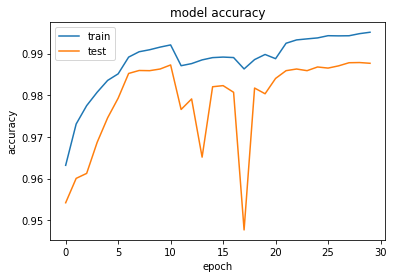

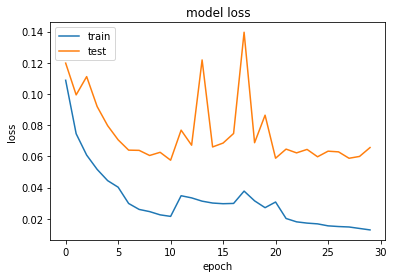

In [17]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Gerando matrix de confusão

In [18]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
Y_pred = model.predict_generator(validation_generator, validation_generator.n // training_config['batch_size']+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))

Instructions for updating:
Please use Model.predict, which supports generators.
Confusion Matrix
[[5745 5541]
 [5733 5552]]


In [19]:
print('Classification Report')
target_names = ['empty', 'noempty']
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

       empty       0.50      0.51      0.50     11286
     noempty       0.50      0.49      0.50     11285

    accuracy                           0.50     22571
   macro avg       0.50      0.50      0.50     22571
weighted avg       0.50      0.50      0.50     22571



Acurácia: 0.5005
Sensitividade: 0.5090
Especificidade: 0.4920


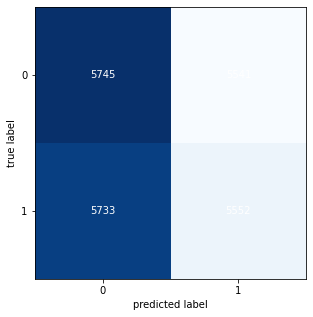

In [20]:
cm=confusion_matrix(validation_generator.classes, y_pred)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

print("Acurácia: {:.4f}".format(acc))
print("Sensitividade: {:.4f}".format(sensitivity))
print("Especificidade: {:.4f}".format(specificity))

from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=cm ,  figsize=(5, 5))
plt.show()

#### Classificação Empty e NoEmpty 67, 42% de Acurácia.

Também estamos obtendo 21,24% de sensibilidade e 78,8% de especificidade, o que implica que:

Sensibilidade: indica que  a capacidade indentificar o que é background (empty) com o modelo é de 21,24%.

Especificidade: indica que capacidade indentificar os animais(NoEmpty) com o modelo é de 78,8%.

Dessa forma podemos supor: 

1- A rede acabou se adaptando demais ao modelo, ocasionando um overfiting

2- Houve uma grande dificuldade da rede em identificar o empty. Dessa forma, implica-se supor:

    2.1 - O modelo acabou por deduzir que devido o empty aparecer em todos os casos com animais, ele se adaptou             de tal modo que na menor alteração do bakground, o modelo ja classificava como NoEmpty. 